## In this code I have modified the logic and after analysing plotted few charts.Also I timed major steps.

I have kept old assignmet file in the main folder to compare the results with this updated assignment file

In [2]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=d228ce4d4761f8ed14839ec34aa3f8283a841cb31c26297f3a1ee48503c677e4
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [140]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql import  Window
import pyspark.sql.types as T
from pyspark.sql.functions import unix_timestamp, from_unixtime
import time

Starting spark session

In [155]:
start_time = time.time()
spark = SparkSession.builder.getOrCreate()
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.4f} seconds")

Execution Time: 0.0221 seconds


Reading Transaction csv file

In [82]:
df_t = spark.read.csv('/content/Transaction.csv', inferSchema = True , header=True)
df_t = df_t.withColumnRenamed('market_price', 'market_price_1') \
 .withColumnRenamed('product', 'product_1')
df_t.show(3)

+----------+-------------+----------+---------+--------------------+--------------+--------+----------+
|CustomerID|TransactionNo|      Date|ProductNo|           product_1|market_price_1|Quantity|CustomerNo|
+----------+-------------+----------+---------+--------------------+--------------+--------+----------+
|         1|       581482|01-01-2021|    22485|Garlic Oil - Vege...|         220.0|      12|     17490|
|         2|       581475|04-01-2021|    22596|Water Bottle - Or...|         180.0|      36|     13069|
|         2|       581475|05-01-2021|    23235|Brass Angle Deep ...|         250.0|      12|     13069|
+----------+-------------+----------+---------+--------------------+--------------+--------+----------+
only showing top 3 rows



In [83]:
df_p = spark.read.csv('/content/Product.csv', inferSchema = True , header=True)
df_p.show(3)

+---------+--------------------+--------------------+--------------------+-----------------+------------+------+
|ProductNo|            category|        sub_category|             product|            brand|market_price|rating|
+---------+--------------------+--------------------+--------------------+-----------------+------------+------+
|    22485|    Beauty & Hygiene|           Hair Care|Garlic Oil - Vege...|Sri Sri Ayurveda |       220.0|   4.1|
|    22596|Kitchen, Garden &...|Storage & Accesso...|Water Bottle - Or...|       Mastercook|       180.0|   2.3|
|    23235|Cleaning & Household|         Pooja Needs|Brass Angle Deep ...|              Trm|       250.0|   3.4|
+---------+--------------------+--------------------+--------------------+-----------------+------------+------+
only showing top 3 rows



Merging product and transaction tables

In [84]:
df = df_t.join(df_p,how='inner', on='ProductNo')
df.show(3)

+---------+----------+-------------+----------+--------------------+--------------+--------+----------+--------------------+--------------------+--------------------+-----------------+------------+------+
|ProductNo|CustomerID|TransactionNo|      Date|           product_1|market_price_1|Quantity|CustomerNo|            category|        sub_category|             product|            brand|market_price|rating|
+---------+----------+-------------+----------+--------------------+--------------+--------+----------+--------------------+--------------------+--------------------+-----------------+------------+------+
|    22485|         1|       581482|01-01-2021|Garlic Oil - Vege...|         220.0|      12|     17490|    Beauty & Hygiene|           Hair Care|Garlic Oil - Vege...|Sri Sri Ayurveda |       220.0|   4.1|
|    22596|        51|       542777|18-05-2021|Golden Dew Intens...|         599.0|       1|     16217|Kitchen, Garden &...|Storage & Accesso...|Water Bottle - Or...|       Masterc

In [85]:
df.count()

4611

Converting date column in df dataframe from string to date format


In [94]:
df = df.withColumn("Date", F.to_date(F.col("Date"), "dd-MM-yyyy"))

partitioning the data into subsets based on unique combinations of 'CustomerID' and 'Category'

 we are using rangeBetween(Window.unboundedPreceding, 0), which means it considers all rows from the beginning of the partition (year) up to the current row.

In [149]:
start_time = time.time()
windowSpec_cumulative = Window.partitionBy('CustomerID', 'Category').orderBy('Date').rangeBetween(Window.unboundedPreceding, 0)
end_time = time.time()
execution_time = end_time - start_time
print(f" Execution Time: {execution_time:.4f} seconds")

 Execution Time: 0.0137 seconds


Calculating cumulative avg price using the windowSpec_cumulative

In [148]:
start_time = time.time()
data1 = df.withColumn('cumulative_avg_price', F.avg('market_price').over(windowSpec_cumulative))
end_time = time.time()
execution_time = end_time - start_time
print(f" Execution Time: {execution_time:.4f} seconds")

 Execution Time: 0.0208 seconds


In [97]:
data1.show(2)

+---------+----------+-------------+----------+--------------------+--------------+--------+----------+----------------+---------------+--------------------+-----------------+------------+------+--------------------+
|ProductNo|CustomerID|TransactionNo|      Date|           product_1|market_price_1|Quantity|CustomerNo|        category|   sub_category|             product|            brand|market_price|rating|cumulative_avg_price|
+---------+----------+-------------+----------+--------------------+--------------+--------+----------+----------------+---------------+--------------------+-----------------+------------+------+--------------------+
|    22485|         1|       581482|2021-01-01|Garlic Oil - Vege...|         220.0|      12|     17490|Beauty & Hygiene|      Hair Care|Garlic Oil - Vege...|Sri Sri Ayurveda |       220.0|   4.1|               220.0|
|    22721|         2|       581475|2021-01-20|Mold & Mildew Rem...|         350.0|      12|     13069|       Baby Care|Diapers & Wi

partitioning the data into subsets based on unique combinations of 'CustomerID' and 'Category'

we define another window specification windowSpec_end_of_year to calculate the average price from the current row to the end of the partition year


In [98]:
start_time = time.time()
windowSpec_end_of_year = Window.partitionBy('CustomerID', 'Category').orderBy('Date').rangeBetween(0, Window.unboundedFollowing)
end_time = time.time()
execution_time = end_time - start_time


creating new data frame data2 based on data1 and adding new column end_of_year_avg_price which is based on windowSpec_end_of_year

In [147]:
start_time = time.time()
data2 = data1.withColumn('end_of_year_avg_price', F.avg('market_price').over(windowSpec_end_of_year))
end_time = time.time()
execution_time = end_time - start_time
print(f" Execution Time: {execution_time:.4f} seconds")

 Execution Time: 0.0217 seconds


In [69]:
data2.show(10)

+---------+----------+-------------+----------+--------------------+--------------+--------+----------+----------------+-----------------+--------------------+-----------------+------------+------+--------------------+---------------------+
|ProductNo|CustomerID|TransactionNo|      Date|             product|market_price_1|Quantity|CustomerNo|        category|     sub_category|             product|            brand|market_price|rating|cumulative_avg_price|end_of_year_avg_price|
+---------+----------+-------------+----------+--------------------+--------------+--------+----------+----------------+-----------------+--------------------+-----------------+------------+------+--------------------+---------------------+
|    22485|         1|       581482|2021-01-01|Garlic Oil - Vege...|         220.0|      12|     17490|Beauty & Hygiene|        Hair Care|Garlic Oil - Vege...|Sri Sri Ayurveda |       220.0|   4.1|               220.0|                220.0|
|    22721|         2|       581475|

we add another column shifted_to_lower_value to data2. This column is determined based on a condition: if the end_of_year_avg_price is less than the cumulative_avg_price, we set it to True, indicating that the customer has shifted to a lower value product from the same category by the end of the year; otherwise, it is set to False.

In [146]:
start_time = time.time()
data2 = data2.withColumn('shifted_to_lower_value',
                         F.when(F.col('end_of_year_avg_price') < F.col('cumulative_avg_price'), True)
                         .otherwise(False))

end_time = time.time()
execution_time = end_time - start_time
print(f" Execution Time: {execution_time:.4f} seconds")

 Execution Time: 0.0275 seconds


In [102]:
data2.show(2)

+---------+----------+-------------+----------+--------------------+--------------+--------+----------+----------------+---------------+--------------------+-----------------+------------+------+--------------------+---------------------+----------------------+
|ProductNo|CustomerID|TransactionNo|      Date|           product_1|market_price_1|Quantity|CustomerNo|        category|   sub_category|             product|            brand|market_price|rating|cumulative_avg_price|end_of_year_avg_price|shifted_to_lower_value|
+---------+----------+-------------+----------+--------------------+--------------+--------+----------+----------------+---------------+--------------------+-----------------+------------+------+--------------------+---------------------+----------------------+
|    22485|         1|       581482|2021-01-01|Garlic Oil - Vege...|         220.0|      12|     17490|Beauty & Hygiene|      Hair Care|Garlic Oil - Vege...|Sri Sri Ayurveda |       220.0|   4.1|               220.

Filtering the data2 dataframe and storing the result in result_df
Also removing few coulums so that in future if I join other tables with result_df column name should not repeat it will create ambiguity while performing column operations

In [104]:
result_df = data2.filter(F.col('shifted_to_lower_value') == True).drop('cumulative_avg_price', 'end_of_year_avg_price','category', 'sub_category','brand','market_price','rating','product' )
result_df.show(10)

+---------+----------+-------------+----------+--------------------+--------------+--------+----------+----------------------+
|ProductNo|CustomerID|TransactionNo|      Date|           product_1|market_price_1|Quantity|CustomerNo|shifted_to_lower_value|
+---------+----------+-------------+----------+--------------------+--------------+--------+----------+----------------------+
|    22596|         2|       581475|2021-01-04|Water Bottle - Or...|         180.0|      36|     13069|                  true|
|    23239|         2|       581475|2021-01-07|Creme Soft Soap -...|         162.0|       6|     13069|                  true|
|    21705|         2|       581475|2021-01-08|Germ - Removal Mu...|         199.0|      24|     13069|                  true|
|    22217|         2|       581475|2021-01-13|Biotin & Collagen...|        1098.0|      12|     13069|                  true|
|    22664|         2|       581475|2021-01-19|Face Wash - Oil C...|         110.0|      20|     13069|        

In [105]:
result_df.count()

2346

there are total 39 out of 55 customers who showed downward substitution

In [106]:
result_count_df = result_df.groupBy('CustomerID').agg(F.count(F.lit(1)).alias('Shift_Count'))

# Order the result in descending order based on the 'Shift_Count'
result_count_df = result_count_df.orderBy(F.desc('Shift_Count'))

result_count_df.count()

39

In [107]:
product_df = spark.read.csv('/content/Product.csv', inferSchema = True , header=True)
product_df.show(5)

+---------+--------------------+--------------------+--------------------+-----------------+------------+------+
|ProductNo|            category|        sub_category|             product|            brand|market_price|rating|
+---------+--------------------+--------------------+--------------------+-----------------+------------+------+
|    22485|    Beauty & Hygiene|           Hair Care|Garlic Oil - Vege...|Sri Sri Ayurveda |       220.0|   4.1|
|    22596|Kitchen, Garden &...|Storage & Accesso...|Water Bottle - Or...|       Mastercook|       180.0|   2.3|
|    23235|Cleaning & Household|         Pooja Needs|Brass Angle Deep ...|              Trm|       250.0|   3.4|
|    23272|Cleaning & Household|Bins & Bathroom Ware|Cereal Flip Lid C...|           Nakoda|       176.0|   3.7|
|    23239|    Beauty & Hygiene|    Bath & Hand Wash|Creme Soft Soap -...|            Nivea|       162.0|   4.4|
+---------+--------------------+--------------------+--------------------+-----------------+----

To find all the product categories that are showing downward substitution we are going to join the result_df with the product table

In [150]:
start_time = time.time()
merged_df = result_df.join(product_df, on='ProductNo', how='inner')
merged_df = merged_df.drop('CustomerID')
end_time = time.time()
execution_time = end_time - start_time
print(f" Execution Time: {execution_time:.4f} seconds")

 Execution Time: 0.0370 seconds


In [119]:
merged_df.show(5)

+---------+-------------+----------+--------------------+--------------+--------+----------+----------------------+--------------------+--------------------+--------------------+-----------------+------------+------+
|ProductNo|TransactionNo|      Date|           product_1|market_price_1|Quantity|CustomerNo|shifted_to_lower_value|            category|        sub_category|             product|            brand|market_price|rating|
+---------+-------------+----------+--------------------+--------------+--------+----------+----------------------+--------------------+--------------------+--------------------+-----------------+------------+------+
|    22596|       581475|2021-01-04|Water Bottle - Or...|         180.0|      36|     13069|                  true|    Beauty & Hygiene|   Fragrances & Deos|Golden Dew Intens...|Dorall Collection|       599.0|   4.0|
|    22596|       581475|2021-01-04|Water Bottle - Or...|         180.0|      36|     13069|                  true|Foodgrains, Oil &

In [152]:
# Grouping by 'product_category' and counting the occurrences
start_time = time.time()
category_counts = merged_df.groupBy('category').count()

end_time = time.time()
execution_time = end_time - start_time
print(f"Step 1 Execution Time: {execution_time:.4f} seconds")

Step 1 Execution Time: 0.0225 seconds


In [153]:

category_counts.count()

11

In [112]:
category_counts = category_counts.orderBy(F.desc('count'))
category_counts.show()

+--------------------+-----+
|            category|count|
+--------------------+-----+
|    Beauty & Hygiene| 1978|
|Gourmet & World Food| 1180|
|Kitchen, Garden &...|  930|
|Foodgrains, Oil &...|  867|
|Snacks & Branded ...|  747|
|Cleaning & Household|  589|
|Bakery, Cakes & D...|  248|
|           Beverages|  177|
| Fruits & Vegetables|  135|
|   Eggs, Meat & Fish|  103|
|           Baby Care|   76|
+--------------------+-----+



reading customer table.

In [113]:
customer_df = spark.read.csv('/content/Customers.csv', inferSchema = True , header=True)

In [114]:
customer_df.show(5)

+----------+----------+------+---+-------------+---------------+-----------+-------------+------+
|CustomerID|      Name|Gender|Age|   Profession|Work Experience|Family Size|Annual Income|  City|
+----------+----------+------+---+-------------+---------------+-----------+-------------+------+
|         1|Muhammad+1|  Male| 19|   Healthcare|              1|          4|? 5,43,000.00|Mumbai|
|         2|       Sai|  Male| 21|     Engineer|              3|          3|? 6,74,000.00|Mumbai|
|         3|     Advik|Female| 20|     Engineer|              1|          1|? 8,25,000.00|Nagpur|
|         4|     Rudra|Female| 23|       Lawyer|              0|          2|? 5,12,000.00|  Pune|
|         5|   Aayansh|Female| 31|Entertainment|              2|          6|? 7,25,000.00|  Pune|
+----------+----------+------+---+-------------+---------------+-----------+-------------+------+
only showing top 5 rows



Inner joining result_df and customer table to get the details of all the customers who have shown downward substitution

In [123]:
merged_df2 = result_df.join(customer_df, on='CustomerID', how='inner')
merged_df2 = merged_df2.drop('shifted_to_lower_value')
merged_df2.show(5)

+----------+---------+-------------+----------+--------------------+--------------+--------+----------+----+------+---+----------+---------------+-----------+-------------+------+
|CustomerID|ProductNo|TransactionNo|      Date|           product_1|market_price_1|Quantity|CustomerNo|Name|Gender|Age|Profession|Work Experience|Family Size|Annual Income|  City|
+----------+---------+-------------+----------+--------------------+--------------+--------+----------+----+------+---+----------+---------------+-----------+-------------+------+
|         2|    22596|       581475|2021-01-04|Water Bottle - Or...|         180.0|      36|     13069| Sai|  Male| 21|  Engineer|              3|          3|? 6,74,000.00|Mumbai|
|         2|    23239|       581475|2021-01-07|Creme Soft Soap -...|         162.0|       6|     13069| Sai|  Male| 21|  Engineer|              3|          3|? 6,74,000.00|Mumbai|
|         2|    21705|       581475|2021-01-08|Germ - Removal Mu...|         199.0|      24|     130

In [124]:
unique_customer_ids = merged_df2.select('CustomerID').distinct()

In [125]:
# Out of 55 Customers 39 Customers Showed Downward Substitution
unique_customer_ids.count()

39

Perform an inner join on 'CustomerID' column between customer table and unique_customer_ids

In [154]:
start_time = time.time()
joined_df = customer_df.join(unique_customer_ids, on='CustomerID', how='inner')
joined_df.show(5)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.4f} seconds")

+----------+---------+------+---+----------+---------------+-----------+-------------+------+
|CustomerID|     Name|Gender|Age|Profession|Work Experience|Family Size|Annual Income|  City|
+----------+---------+------+---+----------+---------------+-----------+-------------+------+
|        31|    Aidan|  Male| 60|    Artist|              0|          3|? 9,36,000.00|Mumbai|
|        53|   Saumya|Female| 31|    Artist|              1|          1|? 8,32,000.00|Nagpur|
|        34|    Tejas|  Male| 18| Homemaker|              9|          7|? 9,01,000.00|Nagpur|
|        28|Riyaannew|  Male| 35|    Artist|              1|          3|? 8,25,000.00|Nagpur|
|        27|   Nathan|Female| 45|Healthcare|              9|          8|? 6,74,000.00|Mumbai|
+----------+---------+------+---+----------+---------------+-----------+-------------+------+
only showing top 5 rows

Execution Time: 1.1145 seconds


For plotting the graphs I'm using Pandas to convert pyspark dataframe to pandas data frame

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

In [128]:
pd_category_counts = category_counts.toPandas()

In [129]:
pd_category_counts.head(3)

,category,count
0,Beauty & Hygiene,1978
1,Gourmet & World Food,1180
2,"Kitchen, Garden & Pets",930


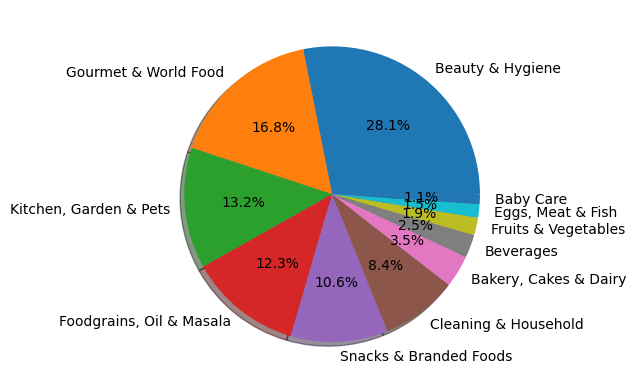

In [130]:
plt.pie(pd_category_counts['count'],labels = pd_category_counts['category'],autopct = '%0.1f%%', shadow=True )
plt.show()

**Above chart shows Downwards Substitution per Category**

In [131]:
pd_merged_df = merged_df.toPandas()
pd_merged_df.head(2)

,ProductNo,TransactionNo,Date,product_1,market_price_1,Quantity,CustomerNo,shifted_to_lower_value,category,sub_category,product,brand,market_price,rating
0,22596,581475,2021-01-04,Water Bottle - Orange,180.0,36,13069,True,Beauty & Hygiene,Fragrances & Deos,Golden Dew Intense For Women,Dorall Collection,599.0,4.0
1,22596,581475,2021-01-04,Water Bottle - Orange,180.0,36,13069,True,"Foodgrains, Oil & Masala",Organic Staples,Organic Brown Rice 5 Kg + Multigrain Atta 5 Kg...,bb Royal,769.0,NaN


Top 10 brands that where people showed downward substitution

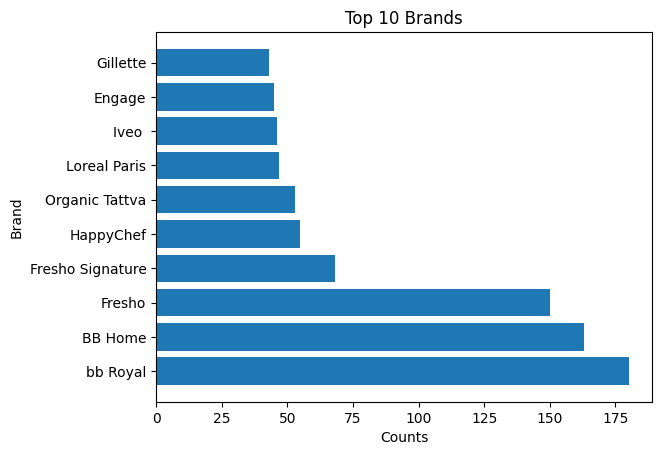

In [133]:
top_brands = pd_merged_df['brand'].value_counts(ascending = False).head(10)
plt.barh(top_brands.index, top_brands.values)

plt.xlabel('Counts')
plt.ylabel('Brand')
plt.title('Top 10 Brands')
plt.show()

Top 10 Brands where people showed less interest

In [134]:
pd_joined_df = joined_df.toPandas()
pd_joined_df.head(3)

,CustomerID,Name,Gender,Age,Profession,Work Experience,Family Size,Annual Income,City
0,31,Aidan,Male,60,Artist,0,3,"? 9,36,000.00",Mumbai
1,53,Saumya,Female,31,Artist,1,1,"? 8,32,000.00",Nagpur
2,34,Tejas,Male,18,Homemaker,9,7,"? 9,01,000.00",Nagpur


25 women and 14 men showed this behaviour

In [135]:
pd_joined_df['Gender'].value_counts()

Female    26
Male      13
Name: Gender, dtype: int64

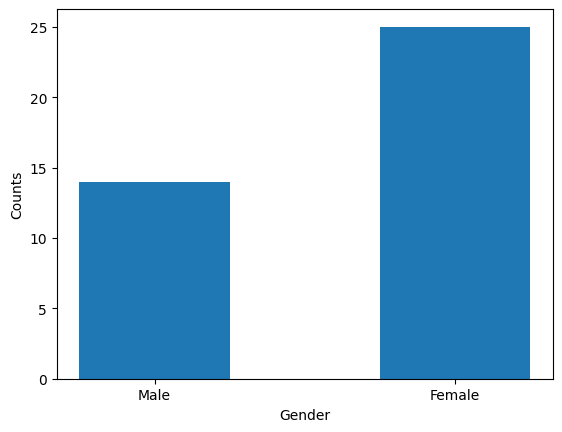

In [136]:
count = [14,25]
gender = ['Male','Female']
plt.bar(gender,count,width = 0.5)
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.show()

Above chart shows downward substitution per gender

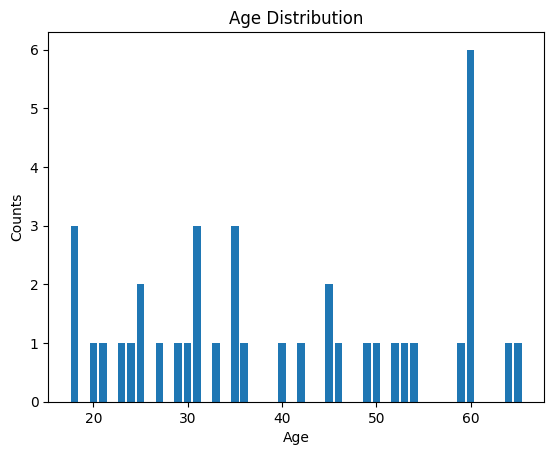

In [137]:
a = pd_joined_df['Age'].unique()
b = pd_joined_df['Age'].value_counts()

# Create a bar plot
plt.bar(a, b)

plt.xlabel('Age')
plt.ylabel('Counts')
plt.title('Age Distribution')

plt.show()

Above chart shows people in 60's shown highest downward substitution

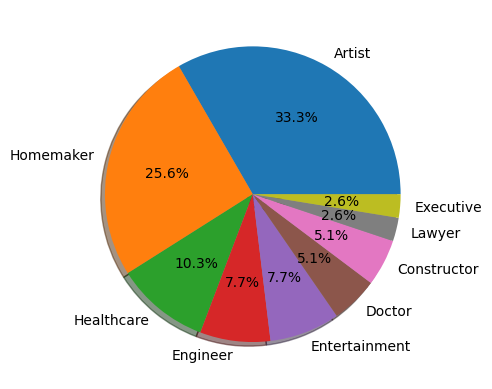

In [138]:
plt.pie(pd_joined_df['Profession'].value_counts(ascending=False), labels =pd_joined_df['Profession'].unique(),autopct = '%0.1f%%', shadow=True)
plt.show()

Artist,homemaker, Heathcare professionals shown maximum downward substitution

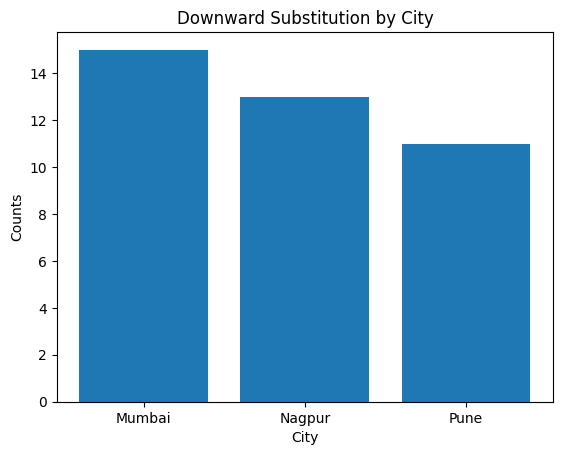

In [139]:
y = pd_joined_df['City'].value_counts().values.tolist()
x = pd_joined_df['City'].unique().tolist()
plt.bar(x,y)
plt.xlabel('City')
plt.ylabel('Counts')
plt.title('Downward Substitution by City')
plt.show()

downward substitution is maximum in Mumbai followed by Nagpur and Pune